Other 제외 총 활동 시간: 53.59분


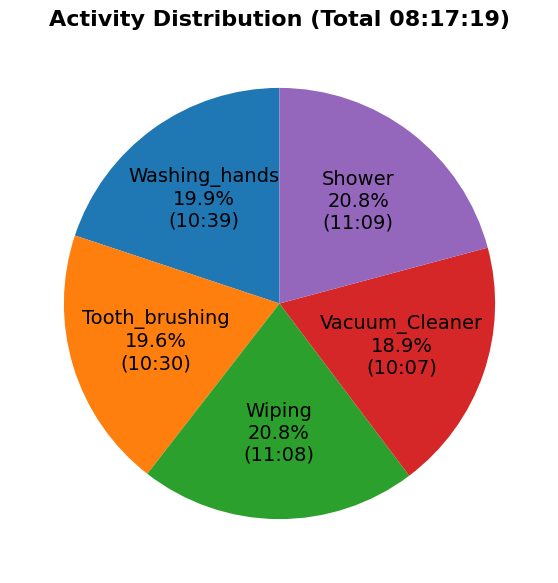

In [4]:
# Activity Time Distribution Pie Charts
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
DATA_DIR = Path('../../Data/Experiment_Data/2_PreprocessDataset')
PARTICIPANT = '201'
ANNOTATION_CSV = DATA_DIR / PARTICIPANT / f"{PARTICIPANT}_Annotation_processed.csv"

def load_elapsed(df_path: Path) -> pd.DataFrame:
    df = pd.read_csv(df_path)
    df['elapsed_td'] = pd.to_timedelta(df['Time'], unit='s')
    return df


def compute_intervals(df: pd.DataFrame, include_other: bool=True) -> list:
    intervals = []
    prev = pd.Timedelta(0)
    current = None
    for _, row in df.iterrows():
        td = row.elapsed_td
        if row.Event == 'Start':
            if include_other and td > prev:
                intervals.append(('Other', prev, td))
            current = row.Activity
            prev = td
        elif row.Event == 'End' and current == row.Activity:
            intervals.append((current, prev, td))
            prev = td
            current = None
    if include_other:
        last = df['elapsed_td'].max()
        if prev < last:
            intervals.append(('Other', prev, last))
    return intervals


def sum_durations(intervals: list) -> dict:
    dur = {}
    for act, s, e in intervals:
        dur[act] = dur.get(act, 0) + (e - s).total_seconds()
    return dur


def make_autopct(total: float):
    def autopct(pct):
        sec = pct/100. * total
        h = int(sec // 3600)
        m = int((sec % 3600) // 60)
        s = int(sec % 60)
        return f"{pct:.1f}%\n{h}h{m:02d}m{s:02d}s"
    return autopct


def plot_pie_distribution(dur_dict: dict, include_other: bool=True):
    labels = list(dur_dict.keys())
    sizes = list(dur_dict.values())
    total = sum(sizes)
    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        autopct=make_autopct(total),
        startangle=90
    )
    ax.legend(wedges, labels, title="Activity", loc="center left", bbox_to_anchor=(1,0.5))
    h = int(total//3600)
    m = int((total%3600)//60)
    s = int(total%60)
    ax.set_title(f"Time Distribution (Total {h}h{m:02d}m{s:02d}s)")
    plt.tight_layout()
    plt.show()


def plot_pie_active(dur_dict: dict):
    # exclude Other
    if 'Other' in dur_dict:
        dur_dict = {k:v for k,v in dur_dict.items() if k!='Other'}
    labels = list(dur_dict.keys())
    sizes = list(dur_dict.values())
    fig, ax = plt.subplots(figsize=(7,7))
    # autopct with label
    labels_copy = labels.copy()
    sizes_copy = sizes.copy()
    def autopct_label(pct):
        label = labels_copy.pop(0)
        sec = sizes_copy.pop(0)
        m = int(sec // 60)
        s = int(sec % 60)
        return f"{label}\n{pct:.1f}%\n({m:02d}:{s:02d})"
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=None,
        autopct=autopct_label,
        pctdistance=0.6,
        startangle=90
    )
    total_sec = sum(sizes)
    h = int(total_sec//3600)
    m = int((total_sec%3600)//60)
    s = int(total_sec%60)
    ax.set_title(f"Active Distribution (Total {h:02d}:{m:02d}:{s:02d})", fontsize=16, fontweight='bold')
    plt.setp(autotexts, fontsize=14)
    print(f"Active total: {total_sec/60:.2f} minutes")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    df = load_elapsed(ANNOTATION_CSV)
    df_sorted = df.sort_values('elapsed_td').reset_index(drop=True)
    # Plot including Other
    intervals_all = compute_intervals(df_sorted, include_other=True)
    dur_all = sum_durations(intervals_all)
    plot_pie_distribution(dur_all)
    # Plot active only
    intervals_act = compute_intervals(df_sorted, include_other=False)
    dur_act = sum_durations(intervals_act)
    plot_pie_active(dur_act)
